**Final Project - Open source tools for intelligent systems**

Kaggle - https://www.kaggle.com/c/rossmann-store-sales/data


In this notebook we will describe our final project in the course - Open source tools for intelligent systems.

The dataset we chose is the "rossmann store sales", forecasting the sales of a specific store in a specific date.

**WE ALREADY MADE A CSV FILE CONTAINING THE PREPROCESSED DATA SO YOU CAN SKIP TO TRAINING SECTION AFTER UPLOADING IT. (TO SAVE TIME)**

# Visualization and imports

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error
import math

Loading the data (train) and merging the data in "store.csv" with the train data.

In [128]:

train_data = pd.read_csv('train.csv')
store_data = pd.read_csv('store.csv')
test_data = pd.read_csv('test.csv')
train_1_data = train_data.merge(store_data, on = "Store", how = "left")
test_1_data = test_data.merge(store_data, on = "Store", how = "left")




/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We want to look and understand the data, first we look up for some correlations

In [129]:
train_1_data_corr = train_1_data.drop('Sales', axis =1)
corr = train_1_data_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,Store,DayOfWeek,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Store,1.000000,-0.000008,0.024325,-0.000047,0.000058,0.000641,-0.026413,-0.050746,-0.004592,0.008488,0.009865,0.038928
DayOfWeek,-0.000008,1.000000,-0.386445,-0.528963,-0.392925,-0.205388,-0.000025,0.000006,-0.000025,0.000168,0.000174,0.000049
Customers,0.024325,-0.386445,1.000000,0.616768,0.316169,0.071568,-0.102861,-0.030954,0.008931,-0.150159,0.040531,0.028974
Open,-0.000047,-0.528963,0.616768,1.000000,0.295042,0.086171,0.007992,0.001384,0.002771,-0.008309,-0.002430,0.001637
Promo,0.000058,-0.392925,0.316169,0.295042,1.000000,0.067483,0.000138,-0.000023,0.000152,-0.000983,-0.001008,-0.000283
SchoolHoliday,0.000641,-0.205388,0.071568,0.086171,0.067483,1.000000,-0.003689,-0.000526,0.001520,-0.006909,-0.003133,-0.003682
CompetitionDistance,-0.026413,-0.000025,-0.102861,0.007992,0.000138,-0.003689,1.000000,-0.061624,0.025397,-0.139886,-0.054384,-0.109695
CompetitionOpenSinceMonth,-0.050746,0.000006,-0.030954,0.001384,-0.000023,-0.000526,-0.061624,1.000000,-0.060594,-0.009383,-0.036251,0.050326
CompetitionOpenSinceYear,-0.004592,-0.000025,0.008931,0.002771,0.000152,0.001520,0.025397,-0.060594,1.000000,-0.077336,-0.079784,0.012155
Promo2,0.008488,0.000168,-0.150159,-0.008309,-0.000983,-0.006909,-0.139886,-0.009383,-0.077336,1.000000,nan,nan


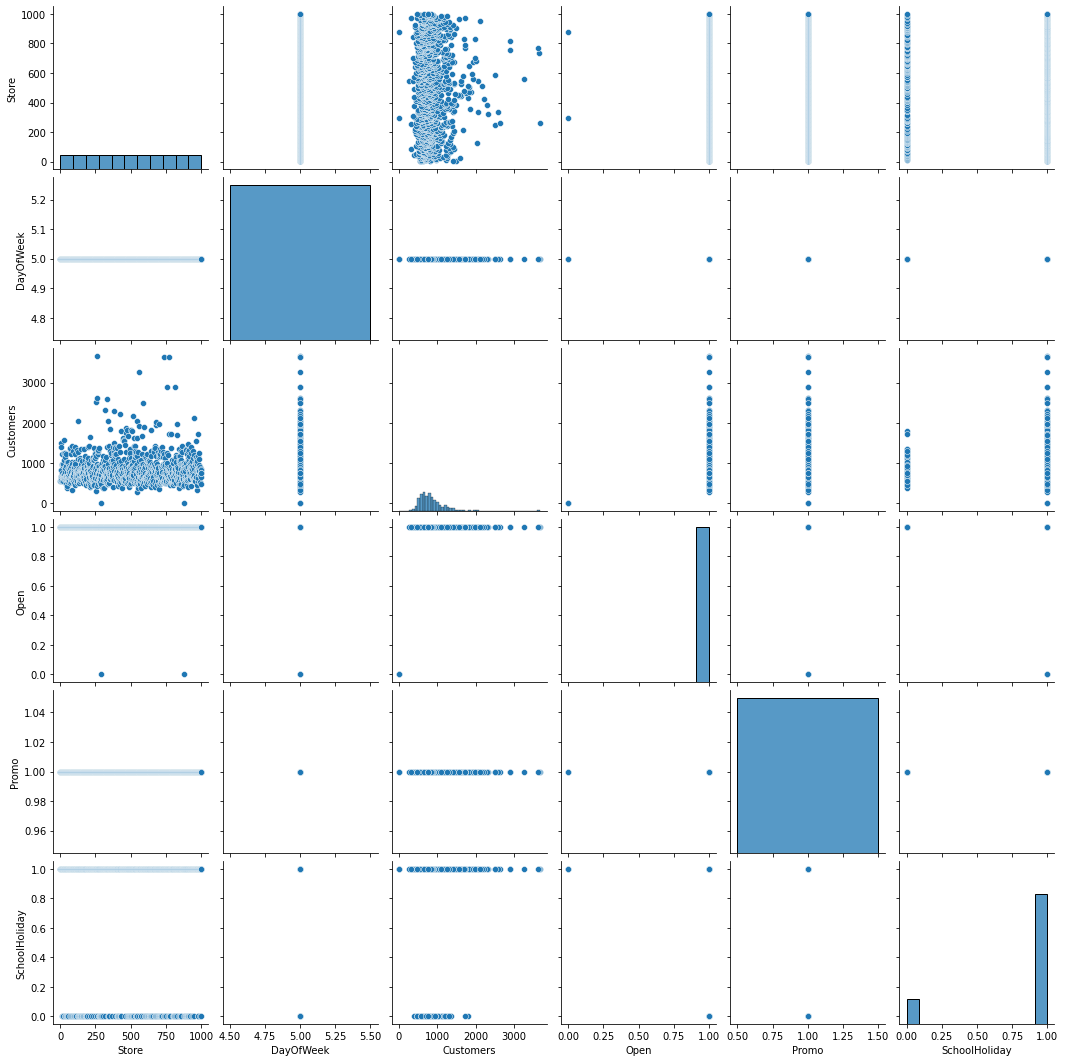

In [ ]:
sns.pairplot(data = train_1_data.drop('Sales', axis =1))

To check: Unique count of non-numeric data
Promo            2
StateHoliday     5
SchoolHoliday    2
StoreType        4
Assortment       3
Promo2           2
PromoInterval    3
dtype: int64


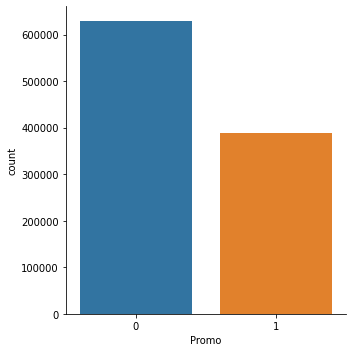

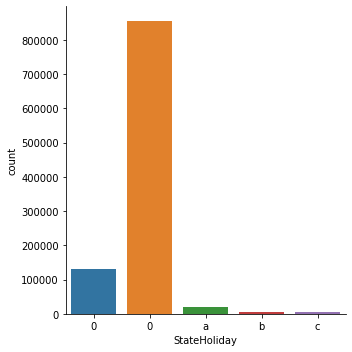

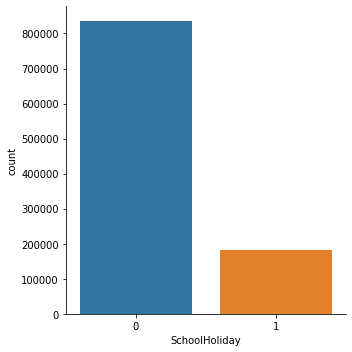

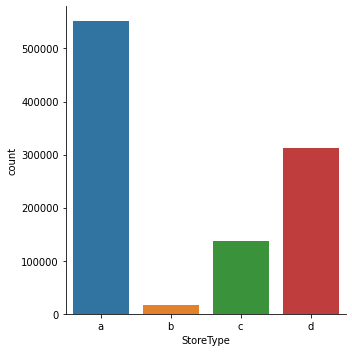

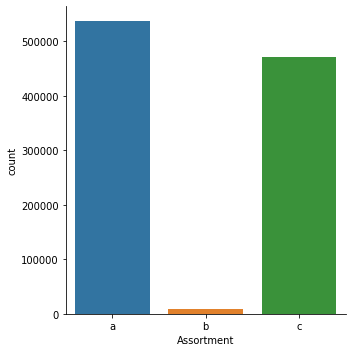

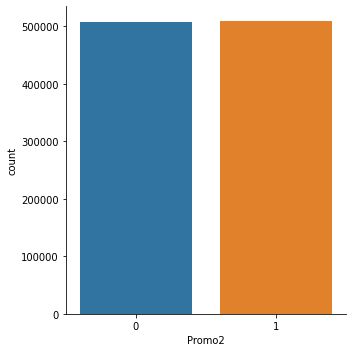

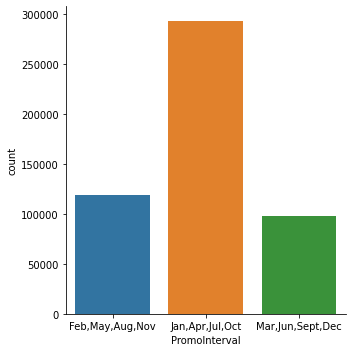

To check: Unique count of non-numeric data
Promo            2
StateHoliday     2
SchoolHoliday    2
StoreType        4
Assortment       3
Promo2           2
PromoInterval    3
dtype: int64


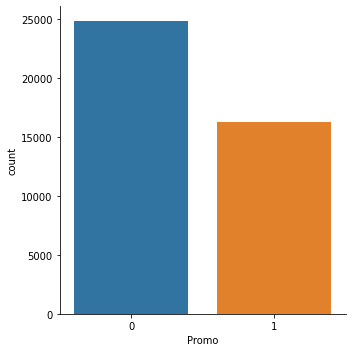

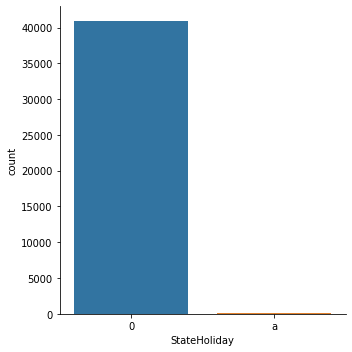

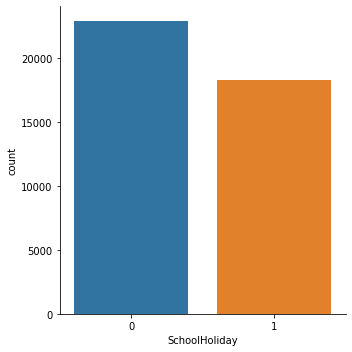

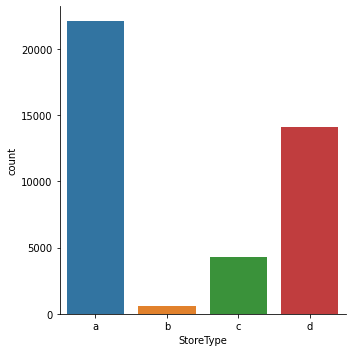

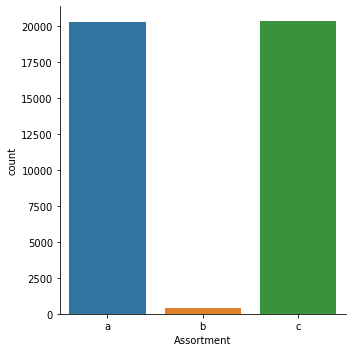

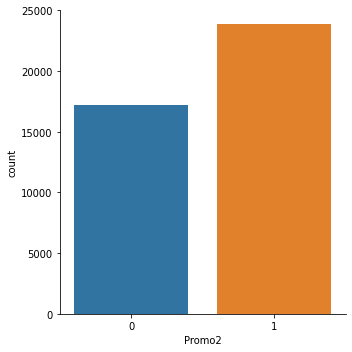

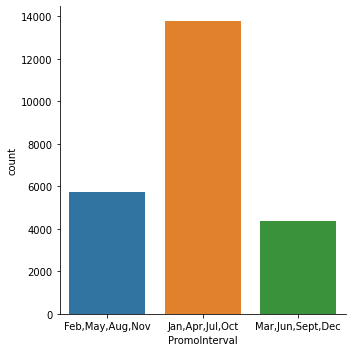

In [130]:
train_data_graph= train_1_data.copy()

train_data_graph['StateHoliday'] = train_1_data.StateHoliday.astype('category')
train_data_graph['Promo'] = train_1_data.Promo.astype('category')
train_data_graph['Promo2'] = train_1_data.Promo2.astype('category')
train_data_graph['Assortment'] = train_1_data.Assortment.astype('category')
train_data_graph['SchoolHoliday'] = train_1_data.SchoolHoliday.astype('category')
train_data_graph['PromoInterval'] = train_1_data.PromoInterval.astype('category')
train_data_graph['StoreType'] = train_1_data.StoreType.astype('category')

test_data_graph= test_1_data.copy()

test_data_graph['StateHoliday'] = test_1_data.StateHoliday.astype('category')
test_data_graph['Promo'] = test_1_data.Promo.astype('category')
test_data_graph['Promo2'] = test_1_data.Promo2.astype('category')
test_data_graph['Assortment'] = test_1_data.Assortment.astype('category')
test_data_graph['SchoolHoliday'] = test_1_data.SchoolHoliday.astype('category')
test_data_graph['PromoInterval'] = test_1_data.PromoInterval.astype('category')
test_data_graph['StoreType'] = test_1_data.StoreType.astype('category')


def categorical_eda(df):
    print("To check: Unique count of non-numeric data")
    print(df.select_dtypes(include=['category']).nunique())
        # Plot count distribution of categorical data
    for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df)
        plt.show()

categorical_eda(train_data_graph)
categorical_eda(test_data_graph)


# Preprocess


In this section we will describe the preprocess we did.

since we are dealing with regression problem we cant have any data that isnt numeric, so the first column we preprocessing is the "StateHoliday", we are making 'dummy variables' out of her rows states - 0,a,b and c.

we will do the same preprocess to the test data we got from kaggle, in this case as we saw earlier in the bar charts, the column 'StateHoliday' doesnt have any "b"'s or "c"'s in it so we just fill this dummy variable with zeros.


In [131]:
train_1_data['StateHoliday'] = train_1_data.StateHoliday.astype('category')
tempdf = pd.get_dummies(train_1_data['StateHoliday'])
train_1_data['0 holiday'] = tempdf['0']
train_1_data['a holiday'] = tempdf['a']
train_1_data['b holiday'] = tempdf['b']
train_1_data['c holiday'] = tempdf['c']

test_1_data['StateHoliday'] = test_1_data.StateHoliday.astype('category')
tempdf = pd.get_dummies(test_1_data['StateHoliday'])
test_1_data['0 holiday'] = tempdf['0']
test_1_data['a holiday'] = tempdf['a']




there are no b holiday and c holiday in the test data therefor we are filling it with zeroes 

In [132]:
test_1_data['b holiday'] = 0
test_1_data['c holiday'] = 0


The open column in the dataset describes whether the store is opened or not.
And if the store is not opened on a day there will not be any Sales.
Therefore it is obvious that if a store is closed then the Sales on that day is zero.
Therefore, let's drop all columns in the merged_df for which Open=0.
And while predicting, Sales of merged_test_df = 0 when Open = 0.


In [133]:
train_1_data = train_1_data[train_1_data.Open == 1].copy()
test_1_data = test_1_data.copy()

In [134]:
train_1_data.info()
train_1_data['Open'].sum()
#every row in column Open equal to 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   Store                      844392 non-null  int64   
 1   DayOfWeek                  844392 non-null  int64   
 2   Date                       844392 non-null  object  
 3   Sales                      844392 non-null  int64   
 4   Customers                  844392 non-null  int64   
 5   Open                       844392 non-null  int64   
 6   Promo                      844392 non-null  int64   
 7   StateHoliday               844392 non-null  category
 8   SchoolHoliday              844392 non-null  int64   
 9   StoreType                  844392 non-null  object  
 10  Assortment                 844392 non-null  object  
 11  CompetitionDistance        842206 non-null  float64 
 12  CompetitionOpenSinceMonth  575773 non-null  float64 
 13  CompetitionOp

844392

Now we separating the year, month, day and the week (the current week out of 52 weeks in a year) to columns.

In [135]:

train_1_data["Date"] = pd.to_datetime(train_data["Date"])


train_1_data["Year"] = train_1_data["Date"].dt.year
train_1_data["Month"] = train_1_data["Date"].dt.month
train_1_data["Day"] = train_1_data["Date"].dt.day
train_1_data["WeekOfYear"] = train_1_data["Date"].dt.week




test_1_data["Date"] = pd.to_datetime(test_data["Date"])


test_1_data["Year"] = test_1_data["Date"].dt.year
test_1_data["Month"] = test_1_data["Date"].dt.month
test_1_data["Day"] = test_1_data["Date"].dt.day
test_1_data["WeekOfYear"] = test_1_data["Date"].dt.week




test_1_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         41088 non-null  int64         
 1   Store                      41088 non-null  int64         
 2   DayOfWeek                  41088 non-null  int64         
 3   Date                       41088 non-null  datetime64[ns]
 4   Open                       41077 non-null  float64       
 5   Promo                      41088 non-null  int64         
 6   StateHoliday               41088 non-null  category      
 7   SchoolHoliday              41088 non-null  int64         
 8   StoreType                  41088 non-null  object        
 9   Assortment                 41088 non-null  object        
 10  CompetitionDistance        40992 non-null  float64       
 11  CompetitionOpenSinceMonth  25872 non-null  float64       
 12  Comp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Calculating the competition time between the start and the sell's date.

In [136]:
def calc_duration_competition(data):
    data['CompetitionOpenTime'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpenTime'] = data['CompetitionOpenTime'].apply(lambda x:0 if x<0 else x).fillna(0)

In [137]:
calc_duration_competition(train_1_data)
calc_duration_competition(test_1_data)


In [138]:
display(train_1_data[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Year', 'Month','CompetitionOpenTime']].sample(8))

,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Year,Month,CompetitionOpenTime
532200,NaN,NaN,2014,3,0.0
733237,NaN,NaN,2013,9,0.0
895352,7.0,2006.0,2013,4,81.0
564317,NaN,NaN,2014,2,0.0
733478,10.0,2011.0,2013,9,23.0
525059,NaN,NaN,2014,3,0.0
215727,NaN,NaN,2015,1,0.0
740171,9.0,2008.0,2013,9,60.0


Calculating the promotion time between the start and the sell's date.

In [139]:
def check_promo_month(row):#check if promo is given in the particular month
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if(row['Promo2Open'] and month2str[row['Month']] in months):
            return 1
        else:
            return 0
    except:
        return 0
    
def promo_cols(data): #calculate duration of promotion(in months)
    data['Promo2Open'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek)*7/30
    data['Promo2Open'] = data['Promo2Open'].apply(lambda x: 0 if x < 0 else x).fillna(0)*data['Promo2']#only when there is promo
    #whether a new round of promotion started in curent month
    data['IsPromo2Month'] = data.apply(check_promo_month, axis=1) * data['Promo2']

In [140]:
train_1_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  category      
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64

In [141]:

# train_1_data['Promo'] = train_1_data['Promo'].apply(lambda x: 0 if x < 0 else x).fillna(0)
# train_1_data['Promo2'] = train_1_data['Promo2'].apply(lambda x: 0 if x < 0 else x).fillna(0)
# train_1_data['PromoInterval'] = train_1_data['PromoInterval'].fillna(0)



# test_1_data['Promo'] = train_1_data['Promo'].apply(lambda x: 0 if x < 0 else x).fillna(0)
# test_1_data['Promo2'] = train_1_data['Promo2'].apply(lambda x: 0 if x < 0 else x).fillna(0)
# test_1_data['PromoInterval'] = test_1_data['PromoInterval'].fillna(0)

promo_cols(train_1_data)
promo_cols(test_1_data)

In [142]:
#train_1_data['PromoInterval']

train_1_data[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(30)


,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
16011,2015-07-17,1,2010.0,13.0,"Jan,Apr,Jul,Oct",63.733333,1
1007490,2013-01-09,0,NaN,NaN,NaN,0.000000,0
209789,2015-01-24,1,2011.0,14.0,"Jan,Apr,Jul,Oct",45.666667,1
976960,2013-02-06,1,2013.0,5.0,"Feb,May,Aug,Nov",0.233333,1
602649,2014-01-07,0,NaN,NaN,NaN,0.000000,0
635834,2013-12-09,0,NaN,NaN,NaN,0.000000,0
587243,2014-01-21,1,2011.0,40.0,"Jan,Apr,Jul,Oct",27.600000,1
832637,2013-06-15,1,2010.0,13.0,"Jan,Apr,Jul,Oct",38.566667,0
1008973,2013-01-08,1,2012.0,22.0,"Jan,Apr,Jul,Oct",7.333333,1
532343,2014-03-11,0,NaN,NaN,NaN,0.000000,0



In this part, we are assuming that if the column CompetitionDistance is NaN than the distance is really big -> no competition or irelevant and filling it with maximum column value instead of the missing values (if we fill it with zeros the model might think the competition is very close to the store).

we also making dummy variables out of the "Assortment" and "StoreType" columns.






In [143]:
max_comp_dist = train_1_data['CompetitionDistance'].max()
train_1_data['CompetitionDistance'] = train_1_data['CompetitionDistance'].fillna(max_comp_dist)

max_comp_dist_test = test_1_data['CompetitionDistance'].max()
test_1_data['CompetitionDistance'] = test_1_data['CompetitionDistance'].fillna(max_comp_dist_test)


In [144]:

train_1_data['Assortment'] = train_1_data.Assortment.astype('category')
tempdf = pd.get_dummies(train_1_data['Assortment'])
train_1_data['a ass'] = tempdf['a']
train_1_data['b ass'] = tempdf['b']
train_1_data['c ass'] = tempdf['c']

train_1_data['StoreType'] = train_1_data.StoreType.astype('category')
tempdf = pd.get_dummies(train_1_data['StoreType'])
train_1_data['type a'] = tempdf['a']
train_1_data['type b'] = tempdf['b']
train_1_data['type c'] = tempdf['c']
train_1_data['type d'] = tempdf['d']
train_1_data.info()



test_1_data['Assortment'] = test_1_data.Assortment.astype('category')
tempdf = pd.get_dummies(test_1_data['Assortment'])
test_1_data['a ass'] = tempdf['a']
test_1_data['b ass'] = tempdf['b']
test_1_data['c ass'] = tempdf['c']

test_1_data['StoreType'] = test_1_data.StoreType.astype('category')
tempdf = pd.get_dummies(test_1_data['StoreType'])
test_1_data['type a'] = tempdf['a']
test_1_data['type b'] = tempdf['b']
test_1_data['type c'] = tempdf['c']
test_1_data['type d'] = tempdf['d']
test_1_data.info()





<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  category      
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  category      
 10  Assortment                 844392 non-null  category      
 11  CompetitionDistance        844392 non-null  float64

In [145]:
train_1_data.info()
test_1_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  category      
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  category      
 10  Assortment                 844392 non-null  category      
 11  CompetitionDistance        844392 non-null  float64

Poping out the columns we preprocessed and wont help us in the prediction. 

In [ ]:
train_1_data.pop('Assortment') #Preprocessed
train_1_data.pop('StateHoliday') #Preprocessed
train_1_data.pop('StoreType') #Preprocessed
train_1_data.pop('PromoInterval') #Preprocessed
train_1_data.pop('Date') #Preprocessed
train_1_data.pop('CompetitionOpenSinceMonth') #More than 50% NaN
train_1_data.pop('CompetitionOpenSinceYear')  #More than 50% NaN
train_1_data.pop('Promo2SinceYear') #More than 50% NaN
train_1_data.pop('Promo2SinceWeek') #More than 50% NaN
train_1_data.pop('Customers')
y = train_1_data['Sales']
train_1_data.pop('Sales') #To use train_1_data as X
train_1_data.info()


test_1_data.pop('Assortment') #Preprocessed
test_1_data.pop('StateHoliday') #Preprocessed
test_1_data.pop('StoreType') #Preprocessed
test_1_data.pop('PromoInterval') #Preprocessed
test_1_data.pop('Date') #Preprocessed
test_1_data.pop('CompetitionOpenSinceMonth') #More than 50% NaN
test_1_data.pop('CompetitionOpenSinceYear')  #More than 50% NaN
test_1_data.pop('Promo2SinceYear') #More than 50% NaN
test_1_data.pop('Promo2SinceWeek') #More than 50% NaN
test_1_data.pop('Id')
test_1_data.info()


In [21]:

corr2 = train_1_data.corr()
display(corr2.style.background_gradient(cmap='coolwarm'))

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,0 holiday,a holiday,b holiday,c holiday,Year,Month,Day,WeekOfYear,CompetitionOpenTime,Promo2Open,IsPromo2Month,a ass,b ass,c ass,type a,type b,type c,type d
Store,1.000000,0.000346,nan,-0.000012,0.000512,-0.023341,0.007736,-0.002015,0.002692,0.000315,0.000428,0.000301,0.001365,-0.000119,0.001292,0.001826,-0.014543,0.000296,-0.007795,0.021366,0.003600,0.005627,-0.001065,0.060829,-0.050689
DayOfWeek,0.000346,1.000000,nan,-0.289265,-0.139315,0.004886,-0.003241,0.010223,0.000860,-0.008676,0.002702,0.002102,-0.019723,0.008534,-0.014402,-0.002006,-0.004694,-0.000763,-0.003901,0.027527,-0.001512,-0.004322,0.038028,-0.003179,-0.004076
Open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Promo,-0.000012,-0.289265,nan,1.000000,0.028964,-0.002108,-0.000324,0.004058,0.006337,-0.002676,-0.008234,0.023994,-0.006408,-0.126452,0.006950,0.002520,0.006604,0.005095,0.001594,-0.012901,0.000943,0.002409,-0.017828,0.002170,0.000996
SchoolHoliday,0.000512,-0.139315,nan,0.028964,1.000000,-0.004209,-0.008245,-0.067899,-0.003174,0.025376,0.018717,-0.038679,0.118485,0.038081,0.079604,-0.000184,-0.006813,0.017579,0.002988,-0.002800,-0.002441,0.001981,-0.003001,0.002763,-0.003305
CompetitionDistance,-0.023341,0.004886,nan,-0.002108,-0.004209,1.000000,-0.137977,-0.002158,0.009752,0.005017,-0.003826,0.000398,0.002611,-0.000233,0.002469,-0.032590,-0.061707,-0.054157,-0.125816,-0.051405,0.136089,-0.036894,-0.072944,-0.097384,0.133070
Promo2,0.007736,-0.003241,nan,-0.000324,-0.008245,-0.137977,1.000000,0.018107,-0.008025,-0.005479,-0.003980,-0.005702,-0.025816,0.001375,-0.024747,0.011533,0.688976,0.419376,-0.007126,-0.013159,0.009725,-0.070917,-0.057567,-0.000872,0.094088
0 holiday,-0.002015,0.010223,nan,0.004058,-0.067899,-0.002158,0.018107,1.000000,-0.072948,-0.033333,-0.023324,-0.084556,0.084659,-0.007178,0.073955,-0.001231,0.002105,0.022024,0.006115,-0.008950,-0.004361,-0.001954,-0.012705,-0.003035,0.008061
a holiday,0.002692,0.000860,nan,0.006337,-0.003174,0.009752,-0.008025,-0.072948,1.000000,-0.000376,-0.000263,0.002586,-0.000484,-0.009770,-0.000801,-0.001614,-0.007154,-0.005844,-0.006429,0.069589,-0.007258,-0.011584,0.083636,-0.003381,-0.009384
b holiday,0.000315,-0.008676,nan,-0.002676,0.025376,0.005017,-0.005479,-0.033333,-0.000376,1.000000,-0.000120,0.003066,-0.007712,-0.006039,-0.007869,-0.002276,-0.006359,0.000104,-0.006046,0.048434,-0.003478,-0.007707,0.065401,-0.005151,-0.006947


removing strong correlations

In [148]:
train_1_data.pop('Month') 
train_1_data.pop('Promo2') 
train_1_data.pop('type b')

test_1_data.pop('Month') 
test_1_data.pop('Promo2') 
test_1_data.pop('type b')

display(corr2.style.background_gradient(cmap='coolwarm'))

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,0 holiday,a holiday,b holiday,c holiday,Year,Month,Day,WeekOfYear,CompetitionOpenTime,Promo2Open,IsPromo2Month,a ass,b ass,c ass,type a,type b,type c,type d
Store,1.000000,0.000346,nan,-0.000012,0.000512,-0.023341,0.007736,-0.002015,0.002692,0.000315,0.000428,0.000301,0.001365,-0.000119,0.001292,0.001826,-0.014543,0.000296,-0.007795,0.021366,0.003600,0.005627,-0.001065,0.060829,-0.050689
DayOfWeek,0.000346,1.000000,nan,-0.289265,-0.139315,0.004886,-0.003241,0.010223,0.000860,-0.008676,0.002702,0.002102,-0.019723,0.008534,-0.014402,-0.002006,-0.004694,-0.000763,-0.003901,0.027527,-0.001512,-0.004322,0.038028,-0.003179,-0.004076
Open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Promo,-0.000012,-0.289265,nan,1.000000,0.028964,-0.002108,-0.000324,0.004058,0.006337,-0.002676,-0.008234,0.023994,-0.006408,-0.126452,0.006950,0.002520,0.006604,0.005095,0.001594,-0.012901,0.000943,0.002409,-0.017828,0.002170,0.000996
SchoolHoliday,0.000512,-0.139315,nan,0.028964,1.000000,-0.004209,-0.008245,-0.067899,-0.003174,0.025376,0.018717,-0.038679,0.118485,0.038081,0.079604,-0.000184,-0.006813,0.017579,0.002988,-0.002800,-0.002441,0.001981,-0.003001,0.002763,-0.003305
CompetitionDistance,-0.023341,0.004886,nan,-0.002108,-0.004209,1.000000,-0.137977,-0.002158,0.009752,0.005017,-0.003826,0.000398,0.002611,-0.000233,0.002469,-0.032590,-0.061707,-0.054157,-0.125816,-0.051405,0.136089,-0.036894,-0.072944,-0.097384,0.133070
Promo2,0.007736,-0.003241,nan,-0.000324,-0.008245,-0.137977,1.000000,0.018107,-0.008025,-0.005479,-0.003980,-0.005702,-0.025816,0.001375,-0.024747,0.011533,0.688976,0.419376,-0.007126,-0.013159,0.009725,-0.070917,-0.057567,-0.000872,0.094088
0 holiday,-0.002015,0.010223,nan,0.004058,-0.067899,-0.002158,0.018107,1.000000,-0.072948,-0.033333,-0.023324,-0.084556,0.084659,-0.007178,0.073955,-0.001231,0.002105,0.022024,0.006115,-0.008950,-0.004361,-0.001954,-0.012705,-0.003035,0.008061
a holiday,0.002692,0.000860,nan,0.006337,-0.003174,0.009752,-0.008025,-0.072948,1.000000,-0.000376,-0.000263,0.002586,-0.000484,-0.009770,-0.000801,-0.001614,-0.007154,-0.005844,-0.006429,0.069589,-0.007258,-0.011584,0.083636,-0.003381,-0.009384
b holiday,0.000315,-0.008676,nan,-0.002676,0.025376,0.005017,-0.005479,-0.033333,-0.000376,1.000000,-0.000120,0.003066,-0.007712,-0.006039,-0.007869,-0.002276,-0.006359,0.000104,-0.006046,0.048434,-0.003478,-0.007707,0.065401,-0.005151,-0.006947


In [149]:


X = train_1_data

#X = pd.read_csv("train_1_data.csv")  # We load as csv to not run the whole code again (may take few hours)
X.info()
train_1_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844392 non-null  int64  
 1   DayOfWeek            844392 non-null  int64  
 2   Open                 844392 non-null  int64  
 3   Promo                844392 non-null  int64  
 4   SchoolHoliday        844392 non-null  int64  
 5   CompetitionDistance  844392 non-null  float64
 6   0 holiday            844392 non-null  uint8  
 7   a holiday            844392 non-null  uint8  
 8   b holiday            844392 non-null  uint8  
 9   c holiday            844392 non-null  uint8  
 10  Year                 844392 non-null  int64  
 11  Day                  844392 non-null  int64  
 12  WeekOfYear           844392 non-null  int64  
 13  CompetitionOpenTime  844392 non-null  float64
 14  Promo2Open           844392 non-null  float64
 15  IsPromo2Month   

**As we can see, all our columns are numbers and no missing values!**

Now we will split the data into 80% train 20% test.
Train data and Test data will contain all the X's and the Y (Sales) columns of the preprocessed data.


In [150]:
scaler = StandardScaler().fit(X)

scaled_features = StandardScaler().fit_transform(train_1_data.values)
X = pd.DataFrame(scaled_features, index=train_1_data.index, columns=train_1_data.columns)


scaled_features = StandardScaler().fit_transform(test_1_data.values)
test_1_data = pd.DataFrame(scaled_features, index=test_1_data.index, columns=test_1_data.columns)

In [154]:
X.info()
test_1_data['Open'] = test_1_data['Open'].fillna(1) #there are 11 missing values in the test set so we will fill it as 1 (the store is open)
test_1_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844392 non-null  float64
 1   DayOfWeek            844392 non-null  float64
 2   Open                 844392 non-null  float64
 3   Promo                844392 non-null  float64
 4   SchoolHoliday        844392 non-null  float64
 5   CompetitionDistance  844392 non-null  float64
 6   0 holiday            844392 non-null  float64
 7   a holiday            844392 non-null  float64
 8   b holiday            844392 non-null  float64
 9   c holiday            844392 non-null  float64
 10  Year                 844392 non-null  float64
 11  Day                  844392 non-null  float64
 12  WeekOfYear           844392 non-null  float64
 13  CompetitionOpenTime  844392 non-null  float64
 14  Promo2Open           844392 non-null  float64
 15  IsPromo2Month   

In [121]:

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

#display(X_train)

,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,0 holiday,a holiday,b holiday,c holiday,Year,Day,WeekOfYear,CompetitionOpenTime,Promo2Open,IsPromo2Month,a ass,b ass,c ass,type a,type c,type d
947192,-1.027014,-1.462191,0.0,1.113726,-0.489947,0.601325,0.393165,-0.02868,-0.013105,-0.00917,-1.070346,-1.363016,-0.948368,-0.643561,0.478701,-0.418274,-1.055326,-0.0991,1.076139,-1.086332,-0.393021,1.504343
512268,-1.257019,1.438566,0.0,-0.897887,-0.489947,1.256287,0.393165,-0.02868,-0.013105,-0.00917,0.216225,1.516024,-0.739887,-0.643561,-0.687165,-0.418274,-1.055326,-0.0991,1.076139,-1.086332,-0.393021,1.504343
1008918,0.219366,-0.882040,0.0,1.113726,-0.489947,-0.597885,0.393165,-0.02868,-0.013105,-0.00917,-1.070346,-0.902370,-1.504318,-0.643561,-0.687165,-0.418274,0.947575,-0.0991,-0.929248,-1.086332,-0.393021,1.504343
521587,-0.016855,0.858414,0.0,1.113726,-0.489947,-0.303035,0.393165,-0.02868,-0.013105,-0.00917,0.216225,0.594731,-0.809380,1.473338,1.828929,-0.418274,0.947575,-0.0991,-0.929248,-1.086332,2.544396,-0.664742
836684,-1.409320,-0.882040,0.0,-0.897887,-0.489947,0.064070,0.393165,-0.02868,-0.013105,-0.00917,-1.070346,-0.556885,0.024545,-0.643561,-0.674874,2.390776,-1.055326,-0.0991,1.076139,0.920529,-0.393021,-0.664742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312959,1.397366,1.438566,0.0,-0.897887,-0.489947,-0.653824,0.393165,-0.02868,-0.013105,-0.00917,0.216225,-0.556885,1.205939,0.108091,-0.687165,-0.418274,-1.055326,-0.0991,1.076139,0.920529,-0.393021,-0.664742
439627,1.692643,-0.882040,0.0,1.113726,-0.489947,-0.501155,0.393165,-0.02868,-0.013105,-0.00917,0.216225,-1.478178,-0.044949,0.767705,0.166165,-0.418274,-1.055326,-0.0991,1.076139,-1.086332,-0.393021,1.504343
159818,-0.573220,-0.882040,0.0,-0.897887,-0.489947,-0.523298,0.393165,-0.02868,-0.013105,-0.00917,1.502796,-0.672047,-0.878874,0.737025,-0.687165,-0.418274,0.947575,-0.0991,-0.929248,0.920529,-0.393021,-0.664742
806510,-1.623784,-1.462191,0.0,-0.897887,-0.489947,-0.594388,0.393165,-0.02868,-0.013105,-0.00917,-1.070346,-0.902370,0.302520,1.212560,-0.687165,-0.418274,-1.055326,-0.0991,1.076139,0.920529,-0.393021,-0.664742


this function measure the metric of the competition - RMSPE

# Training

In [122]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE(y, yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe 


**XGBOOST Regressor**

In [27]:
from xgboost.sklearn import XGBRegressor
from scipy.stats import uniform

steps_xg = [
            ('pca', PCA()),
            ('xg',  XGBRegressor(objective='reg:squarederror',silent = False, n_jobs=3, reg_lambda=1,gamma=0))]

pipe_xg = Pipeline(steps_xg)

pipe_xg.get_params()

parameters = {'xg__learning_rate':  uniform(0, 1),
              'xg__n_estimators':   range(50,300),
              'xg__max_depth':      range(3,10),
              'pca__n_components' : range(10,17)}


rs = RandomizedSearchCV(pipe_xg,
                        param_distributions=parameters,
                        #scoring=make_scorer(mean_squared_error, squared=False),
                        #scoring= RMSPE,
                        n_iter=15,    
                        verbose = 1,
                        #refit = RMSPE,
                        n_jobs = 3,
                        cv = 3              
                        )

rs.fit(X_train, y_train)


model_rs = XGBRegressor(objective='reg:squarederror',silent = False, n_jobs=3, reg_lambda=1,gamma=0,
                    learning_rate = rs.best_params_['xg__learning_rate'],
                    max_depth = rs.best_params_['xg__max_depth'],
                    n_estimators=rs.best_params_['xg__n_estimators']
                    )


model_rs.fit(X_train, y_train)

y_pred_rs = model_rs.predict(X_test)

RMSPE_xgboost = RMSPE(y_test,y_pred_rs)

print(RMSPE(y_test,y_pred_rs))


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed: 123.6min finished


0.2777720161978213


In [28]:
print(rs.best_params_['xg__learning_rate'])
print(rs.best_params_['xg__max_depth'])
print(rs.best_params_['xg__n_estimators'])



0.27317761749799363
7
265


**Linear regression**

In [ ]:
linear_rreg =LinearRegression()
pipe_linear = Pipeline( [('linear' ,linear_rreg)])

pipe_linear.fit(X_train,y_train)
print("intercept = " , linear_rreg.intercept_ )
#for i in range(len(X_train.columns)):
#  print( X_train.columns[i]," = ", linear_rreg.coef_[i])

y_hat = pipe_linear.predict(X_test)
RMSPE_linear = RMSPE(y_hat, y_test)
print( "RMSPE  ",RMSPE_linear)


intercept =  6954.039113810799
RMSPE   0.39544507100877696


**polynomial regression X^2**

In [ ]:
  poly_features = PolynomialFeatures(degree=2)
  poly_reg =LinearRegression()
  pipe_poly = Pipeline( [('poly',poly_features),('linear' ,poly_reg)])

  pipe_poly.fit(X_train,y_train)
  print("intercept = " , poly_reg.intercept_ )

  #for i in range(len(X_train.columns)):
  #  print( X_train.columns[i]," = ", poly_reg.coef_[i])

  y_hat = pipe_poly.predict(X_test)
  RMSPE_linear_degree2 = RMSPE(y_hat, y_test)

print( "RMSPE  ",RMSPE_linear_degree2)

intercept =  -64066151759.65446
RMSPE   0.37248561340289327


In [ ]:

parameters = {'alpha':[0.001,0.009,0.01,.01,0.3,0.5,0.8,1],
              'max_iter': [20,50,100,200,400,600,800],
              'selection': ('cyclic', 'random'),
              'normalize':('True', 'Fasle')
              }
#model 
lasso = Lasso()

clf_lasso = GridSearchCV(lasso, parameters, scoring='neg_root_mean_squared_error')
clf_lasso.fit(X_train[:20000],y_train[:20000])

print("Best parameters set found on development set:")
print()
print(clf_lasso.best_params_)
print()
print("Grid scores on development set:")
print()
means_lasso = clf_lasso.cv_results_['mean_test_score']
stds_lasso = clf_lasso.cv_results_['std_test_score']
for mean, std, params in zip(means_lasso, stds_lasso, clf_lasso.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

y_hat = clf_lasso.predict(X_test[:10000])
RMSPE_lasso = RMSPE(y_hat, y_test[:10000])
print( "RMSPE  ",RMSPE_lasso)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61456515040.5149, tolerance: 15344654.7335439
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61486042209.57512, tolerance: 15276083.106492694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61417281042.95612, tolerance: 15312971.221204976
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62020180308.

Best parameters set found on development set:

{'alpha': 0.01, 'max_iter': 200, 'normalize': 'True', 'selection': 'random'}

Grid scores on development set:

-2788.427 (+/-52.212) for {'alpha': 0.001, 'max_iter': 20, 'normalize': 'True', 'selection': 'cyclic'}
-2798.755 (+/-54.430) for {'alpha': 0.001, 'max_iter': 20, 'normalize': 'True', 'selection': 'random'}
-2788.427 (+/-52.212) for {'alpha': 0.001, 'max_iter': 20, 'normalize': 'Fasle', 'selection': 'cyclic'}
-2800.082 (+/-55.535) for {'alpha': 0.001, 'max_iter': 20, 'normalize': 'Fasle', 'selection': 'random'}
-2775.119 (+/-44.014) for {'alpha': 0.001, 'max_iter': 50, 'normalize': 'True', 'selection': 'cyclic'}
-2784.834 (+/-50.942) for {'alpha': 0.001, 'max_iter': 50, 'normalize': 'True', 'selection': 'random'}
-2775.119 (+/-44.014) for {'alpha': 0.001, 'max_iter': 50, 'normalize': 'Fasle', 'selection': 'cyclic'}
-2785.484 (+/-50.759) for {'alpha': 0.001, 'max_iter': 50, 'normalize': 'Fasle', 'selection': 'random'}
-2772.999 (+/-

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34449257271.2795, tolerance: 19279753.814287506
  positive)


In [160]:
parameters = {'alpha':[0.001,0.009,0.01,.09,1,5,10,25],
              'solver':('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'),
              'max_iter': [100,200,400]}
#model 
ridge = Ridge()

clf_ridge = GridSearchCV(ridge, parameters, scoring='neg_root_mean_squared_error')
clf_ridge.fit(X_train,y_train)

print("Best parameters set found on development set:")
print()
print(clf_ridge.best_params_)
print()
print("Grid scores on development set:")
print()
means_ridge = clf_ridge.cv_results_['mean_test_score']
stds_ridge = clf_ridge.cv_results_['std_test_score']
for mean, std, params in zip(means_ridge, stds_ridge, clf_ridge.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

y_hat = clf_ridge.predict(X_test)
RMSPE_ridge = RMSPE(y_hat, y_test)
print( "RMSPE  ",RMSPE_ridge)

Best parameters set found on development set:

{'alpha': 25, 'max_iter': 200, 'solver': 'sag'}

Grid scores on development set:

-2772.201 (+/-22.170) for {'alpha': 0.001, 'max_iter': 100, 'solver': 'auto'}
-2772.201 (+/-22.170) for {'alpha': 0.001, 'max_iter': 100, 'solver': 'svd'}
-2772.201 (+/-22.170) for {'alpha': 0.001, 'max_iter': 100, 'solver': 'cholesky'}
-2772.209 (+/-22.129) for {'alpha': 0.001, 'max_iter': 100, 'solver': 'lsqr'}
-2772.201 (+/-22.167) for {'alpha': 0.001, 'max_iter': 100, 'solver': 'sparse_cg'}
-2772.195 (+/-22.183) for {'alpha': 0.001, 'max_iter': 100, 'solver': 'sag'}
-2772.201 (+/-22.166) for {'alpha': 0.001, 'max_iter': 100, 'solver': 'saga'}
-2772.201 (+/-22.170) for {'alpha': 0.001, 'max_iter': 200, 'solver': 'auto'}
-2772.201 (+/-22.170) for {'alpha': 0.001, 'max_iter': 200, 'solver': 'svd'}
-2772.201 (+/-22.170) for {'alpha': 0.001, 'max_iter': 200, 'solver': 'cholesky'}
-2772.209 (+/-22.129) for {'alpha': 0.001, 'max_iter': 200, 'solver': 'lsqr'}
-27

# Model selection

In [1]:
RMSPE_xgboost = 0.2777
RMSPE_linear = 0.39544
RMSPE_linear_degree2 = 0.372485
RMSPE_lasso = 0.404419
RMSPE_ridge = 0.39540194625782027

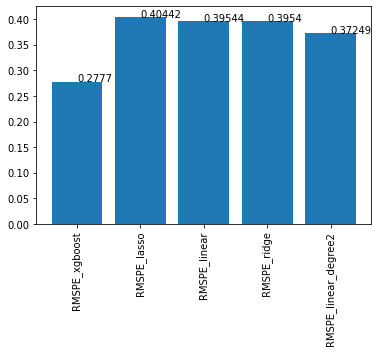

In [5]:

y_bar = [RMSPE_xgboost,  RMSPE_lasso,
         RMSPE_linear, RMSPE_ridge,  RMSPE_linear_degree2]
x_bar = ['RMSPE_xgboost',  'RMSPE_lasso',
         'RMSPE_linear',' RMSPE_ridge', 'RMSPE_linear_degree2']

def addlabels(x, y):
            for i in range(len(x)):
                plt.text(i, round(y[i],5), round(y[i],5))

addlabels(x_bar, y_bar)
plt.bar(x_bar, y_bar)
#y_pred = clf.predict(X_test)
#plt.tight_layout()
plt.xticks(x_bar, x_bar, rotation='vertical')

plt.show()

#MSE = mean_squared_error(y_test,y_pred,squared=False)
#RMSPE = rmspe(y_pred, y_test)
#print(RMSPE)

# Testing 


As we can see, the best model was the XGBoost regressor.
we compared between our models with the RMSPE because it is the measure the competition uses in kaggle.

we found XGBoost regressor's best parameters and now we will predict the test data we got from kaggle using our model.

of course we preprocessed the test data the same way we preprocessed the train.

In [155]:
X_kaggle_test = test_1_data

In [156]:

model_rs = XGBRegressor(objective='reg:squarederror',silent = False, n_jobs=3, reg_lambda=1,gamma=0,
                    learning_rate = 0.27317761749799363,
                    max_depth = 7,
                    n_estimators=265
                    )


model_rs.fit(X_train, y_train)

y_pred_kaggle = model_rs.predict(X_kaggle_test)


display(y_pred_kaggle)


array([ 4758.7065,  8959.284 ,  9648.407 , ..., 11460.    , 13420.944 ,
        6208.829 ], dtype=float32)

In [157]:
samples_submission = pd.read_csv('sample_submission.csv')

samples_submission['Sales'] = y_pred_kaggle

display(samples_submission)

,Id,Sales
0,1,4758.706543
1,2,8959.284180
2,3,9648.407227
3,4,7294.249512
4,5,7757.828125
...,...,...
41083,41084,5953.010742
41084,41085,11534.367188
41085,41086,11460.000000
41086,41087,13420.944336


Download the submission format 

In [159]:
import zipfile
from google.colab import files

compression_opts = dict(method='zip',
                        archive_name='samples_submission.csv') 
 
zip_file = samples_submission.to_csv('samples_submission.zip', index=False,
          compression=compression_opts)  

files.download("samples_submission.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualizing the predicted vs acctual values of the train and test (80-20%) 

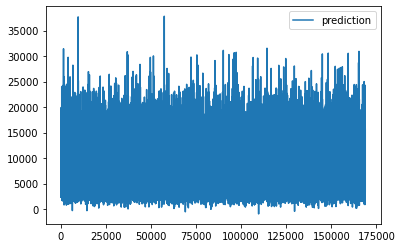

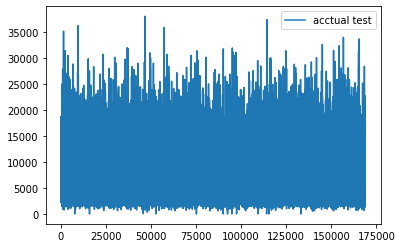

820.4474363504927


In [158]:
from sklearn.metrics import mean_squared_error

y_pred = model_rs.predict(X_test)

test_pd = pd.DataFrame(y_pred,y_test)

x1 = list(range(0,168879))

y1 = y_pred
y2 = y_test

plt.plot(x1,y1, label = "prediction")
plt.legend()
plt.show()
plt.plot(x1,y2,label = "acctual test")

plt.legend()
plt.show()

mse = mean_squared_error(y1, y2)
rmse = math.sqrt(mse)
print(rmse)

our score on kaggle is 0.34863 RMSPE

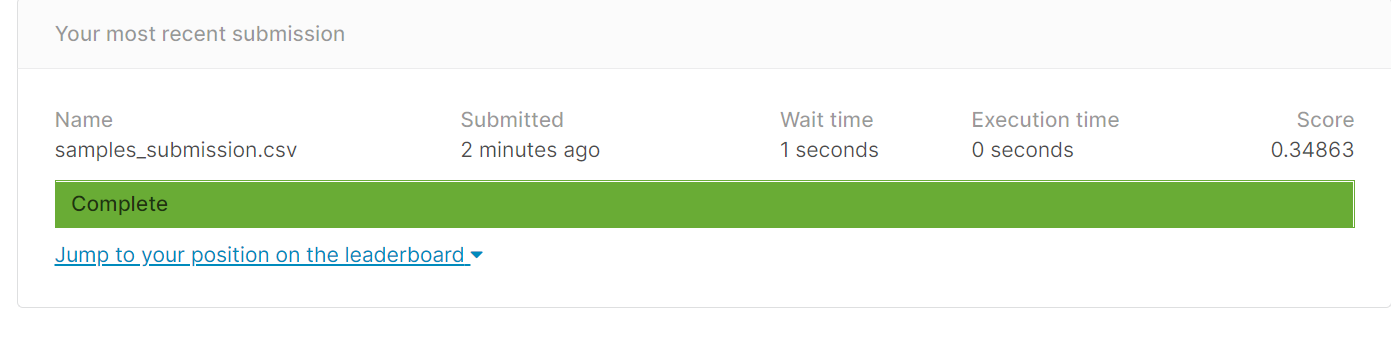